# Trials for KFAC
## Generic setup (~~regression~~ binary classification task)

In [1]:
using Pkg
Pkg.activate(".")
using LaplaceRedux
using LaplaceRedux.Curvature
using LaplaceRedux.Data
using Flux
using Flux.Optimise: update!, Adam
using Plots
using Statistics
using MLUtils
using Zygote

using Printf
using NNlib
using BenchmarkTools
using Tullio
using PrettyPrinting
using LinearAlgebra
using Colors, Plots

using Serialization
using CSV
using Tables
using JSON

  Activating new project at `~/Builds/navimakarov/LaplaceRedux.jl/dev/notebooks/KFAC/sb`


In [2]:
# Init data
n = 2000
data_dict = Dict()

# Classification binary:
xs, y = LaplaceRedux.Data.toy_data_non_linear(n)
X = reduce(hcat, xs)
Y = reduce(hcat, y)
data = zip(xs, y)
data_dict[:classification_binary] = Dict(
    :data => data,
    :X => X,
    :Y => Y,
    :y => y,
    :outdim => 1,
    :loss_fun => :logitbinarycrossentropy,
    :likelihood => :classification,
)



Dict{Symbol, Any} with 7 entries:
  :loss_fun   => :logitbinarycrossentropy
  :y          => [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.0, 0.0…
  :likelihood => :classification
  :X          => [1.66144 1.84068 … -1.62913 -1.53535; 1.95971 1.47485 … 0.7208…
  :Y          => [1.0 1.0 … 0.0 0.0]
  :outdim     => 1
  :data       => zip([[1.66144, 1.95971], [1.84068, 1.47485], [2.0486, 2.29198]…

In [3]:
# Init a NN model

val = data_dict[:classification_binary]

# Unpack:
data = val[:data]
X = val[:X]
y = val[:y]
outdim = val[:outdim]
loss_fun = val[:loss_fun]
likelihood = val[:likelihood]

# Neural network:
n_hidden = 32
D = size(X, 1)
nn = Chain(Dense(D, n_hidden, σ), Dense(n_hidden, outdim))
λ = 0.01
sqnorm(x) = sum(abs2, x)
weight_regularization(λ=λ) = 1 / 2 * λ^2 * sum(sqnorm, Flux.params(nn))
loss(x, y) = getfield(Flux.Losses, loss_fun)(nn(x), y) + weight_regularization()

loss (generic function with 1 method)

In [62]:
yhat = sigmoid(nn(X))
# tensor([[0.5963],
#         [0.5894],
#         [0.5895],
#         ...,
#         [0.7167],
#         [0.6756],
#         [0.6787]], grad_fn=<SigmoidBackward0>)

1×2000 Matrix{Float32}:
 0.596294  0.589417  0.589466  0.568271  …  0.716712  0.675625  0.678703

In [3]:
# Train a NN model

opt = Adam()
epochs = 200
avg_loss(data) = mean(map(d -> loss(d[1], d[2]), data))
show_every = epochs / 10

for epoch in 1:epochs
    for d in data
        gs = gradient(Flux.params(nn)) do
            l = loss(d...)
        end
        update!(opt, Flux.params(nn), gs)
    end
    if epoch % show_every == 0
        println("Epoch " * string(epoch))
        @show avg_loss(data)
    end
end

H_facs = nothing

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(2 => 32, σ)   # 96 parameters
│   summary(x) = "2-element Vector{Float64}"
└ @ Flux ~/.julia/packages/Flux/EHgZm/src/layers/stateless.jl:60


Epoch 20
avg_loss(data) = 0.2865965417020954
Epoch 40
avg_loss(data) = 0.09509227910829936
Epoch 60
avg_loss(data) = 0.07713148846552068
Epoch 80
avg_loss(data) = 0.07278975016174948
Epoch 100
avg_loss(data) = 0.07114890917363521
Epoch 120
avg_loss(data) = 0.07041154312993458
Epoch 140
avg_loss(data) = 0.06998371414254066
Epoch 160
avg_loss(data) = 0.06969246734235789
Epoch 180
avg_loss(data) = 0.06947445884993358
Epoch 200
avg_loss(data) = 0.06929677478314257


In [4]:
# Take one datapoint of the dataset
x_1 = xs[1]
y_1 = y[1]

1.0

## Export data and network

In [56]:
CSV.write("Y.csv", Tables.table(Y'))
CSV.write("X.csv", Tables.table(X'))

"Y.csv"

In [59]:
function serialize_json_nn(nn::Chain)::String
    JSON.json([Dict(:weight => nn.layers[i].weight, :bias => nn.layers[i].bias)
            for i in range(1, length(nn.layers))])
end

write("nn.json", serialize_json_nn(nn))

1342

In [60]:
serialize("nn.jlb", nn)

In [ ]:
nn = deserialize("nn.jlb")

In [97]:
yhat = round.(sigmoid(nn(X)))

1×2000 Matrix{Float32}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

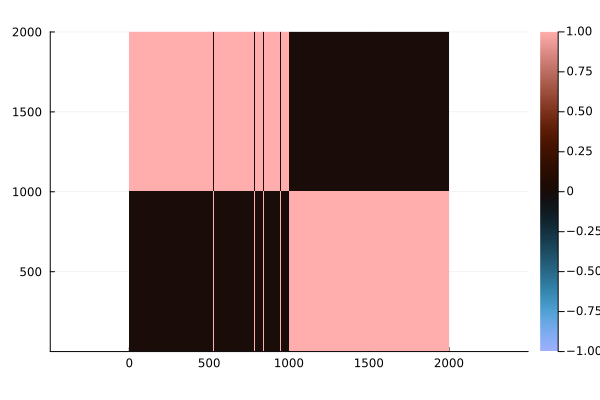

In [102]:
colplot(yhat .== y)

In [103]:
yhat == y

false

In [104]:
yhat[1001:end] == y[1001:end]

true

In [114]:
F

129×129 Matrix{Float64}:
  6.2167e-13   -7.72804e-13   2.43444e-13  …  -5.9251e-14    4.1881e-13
 -7.72804e-13   2.50002e-12  -3.71914e-13      4.40412e-13  -1.65418e-13
  2.43444e-13  -3.71914e-13   6.21901e-13     -3.48403e-13  -1.83015e-13
  6.60249e-13  -6.85181e-13   3.47718e-13     -1.28258e-13   3.63163e-13
  3.96273e-14  -1.54055e-13   5.44697e-14     -5.01768e-13  -5.76283e-13
 -7.06198e-13   2.31268e-12  -4.07842e-13  …   4.74919e-13  -8.55431e-14
 -1.10848e-13   1.81912e-13  -1.13893e-13      3.30208e-13   2.15746e-13
  5.93058e-13  -5.22127e-13   4.38784e-13     -2.47998e-13   1.72098e-13
 -2.52839e-13   2.25678e-13  -1.61982e-13     -4.19701e-14  -5.45906e-13
  3.0198e-13   -4.8411e-13    8.00567e-14      8.96069e-16   3.03191e-13
  1.08339e-13  -5.12159e-13   1.81579e-13  …  -4.38763e-13  -1.90881e-13
  2.75911e-13  -4.515e-13     7.10307e-14      4.59872e-15   2.96752e-13
 -2.58315e-13   2.31909e-13  -1.63677e-13     -4.51298e-14  -5.60839e-13
  ⋮                        

## KFAC Fisher

In [31]:
# todo: obtain the kronecker factors approximating the hessian for the first datapoint for the first layer

# References.
# https://towardsdatascience.com/introducing-k-fac-and-its-application-for-large-scale-deep-learning-4e3f9b443414
# Daxberger et al.
# Martens & Grosse

a = Flux.activations(nn, x_1)
acts = a

(Float32[0.00071874616, 0.00016742604, 0.87883204, 0.00068176794, 0.9698986, 0.000117275755, 0.94732326, 0.086328626, 0.00010406953, 0.023307256  …  1.6348773f-5, 0.0029512192, 5.905252f-5, 0.00018570888, 4.424152f-5, 0.00015386227, 0.8745206, 5.9462036f-5, 7.955101f-5, 0.00019166034], Float32[5.952421])

In [12]:
yhat_1 = nn(x_1)

1-element Vector{Float32}:
 5.952421

In [30]:
yhat_1 == a[2]

true

In [15]:
foreach(x -> (@show size(x)), acts)

size(x) = (32,)
size(x) = (1,)


In [22]:
loss_m = m -> Flux.Losses.logitbinarycrossentropy(m(x_1), y_1)
grads = gradient(loss_m, nn)[1]

(layers = ((weight = Float32[-7.850426f-6 -6.921907f-6; 4.4020385f-6 3.8813814f-6; … ; -1.8888776f-6 -1.6654681f-6; 3.8544867f-6 3.3985918f-6], bias = Float32[-1.5766433f-6, 8.84085f-7, -0.000361299, -1.6891946f-6, -0.00010785097, 5.020244f-7, -0.00018720127, -0.00047395955, -4.6244327f-7, 0.00023837869  …  -4.906786f-8, 1.682414f-5, -3.020611f-7, 7.5977243f-7, -2.407904f-7, 8.194232f-7, -0.00037449668, 3.3323127f-7, -3.7935342f-7, 7.741172f-7], σ = nothing), (weight = Float32[-1.863564f-6 -4.34102f-7 … -2.0625976f-7 -4.9693665f-7], bias = Float32[-0.0025927986], σ = nothing)),)

In [39]:
W = Any[nothing, nothing]
g = Any[nothing, nothing]

2-element Vector{Any}:
 nothing
 nothing

In [42]:
W[1] = grads.layers[1].weight
W[2] = grads.layers[2].weight
W[1]

32×2 Matrix{Float32}:
 -7.85043f-6   -6.92191f-6
  4.40204f-6    3.88138f-6
 -0.00179898   -0.0015862
 -8.41084f-6   -7.41604f-6
 -0.000537012  -0.000473496
  2.49968f-6    2.20403f-6
 -0.000932113  -0.000821866
 -0.00235994   -0.00208082
 -2.3026f-6    -2.03026f-6
  0.00118694    0.00104655
 -1.41018f-6   -1.24339f-6
 -1.18624f-6   -1.04594f-6
  9.17759f-5    8.0921f-5
  ⋮            
 -9.45684f-6   -8.33832f-6
  0.0132107     0.0116482
 -2.44319f-7   -2.15422f-7
  8.37708f-5    7.38627f-5
 -1.50402f-6   -1.32613f-6
  3.78306f-6    3.33561f-6
 -1.19894f-6   -1.05714f-6
  4.08007f-6    3.5975f-6
 -0.00186469   -0.00164415
  1.65923f-6    1.46298f-6
 -1.88888f-6   -1.66547f-6
  3.85449f-6    3.39859f-6

In [43]:
pinv(a[1])

1×32 transpose(::Vector{Float32}) with eltype Float32:
 0.000130664  3.04371f-5  0.159767  …  1.08099f-5  1.44619f-5  3.48427f-5

In [46]:
pinv(a[1]) * a[1]

1.0000002f0

In [50]:
g[1] = grads.layers[1].weight * pinv(x_1')

32-element Vector{Float64}:
 -1.576643303712004e-6
  8.840850297488131e-7
 -0.0003612990100679568
 -1.6891946298849152e-6
 -0.00010785096801257645
  5.02024426779488e-7
 -0.00018720126588310092
 -0.0004739595477057084
 -4.6244328219434377e-7
  0.00023837869781410552
 -2.832142629629221e-7
 -2.3823991529586152e-7
  1.8431845650675716e-5
  ⋮
 -1.8992675064377666e-6
  0.0026531709389373886
 -4.906786288557403e-8
  1.6824140754190347e-5
 -3.0206109810569945e-7
  7.597724517642064e-7
 -2.4079040231335137e-7
  8.194232093232953e-7
 -0.00037449668775830396
  3.3323128283762444e-7
 -3.793534335116664e-7
  7.741172480427405e-7

In [51]:
g[2] = grads.layers[2].weight * pinv(a[1]')

1-element Vector{Float32}:
 -0.002592799

In [54]:
isapprox(W[2], g[2] * a[1]')

true

In [55]:
A = Any[nothing, nothing]
G = Any[nothing, nothing]

2-element Vector{Any}:
 nothing
 nothing

In [64]:
A_0 = x_1 * x_1'
A[1] = a[1] * a[1]'
# A[2] = a[2] * a[2]'
G[1] = g[1] * g[1]'
G[2] = g[2] * g[2]'

1×1 Matrix{Float32}:
 6.722607f-6

In [70]:
K = Kron([(A[1], G[1]), (A[2], G[2])])

Kron1(Tuple{AbstractArray, AbstractArray}[(Float32[5.1659606f-7 1.2033682f-7 … 5.7176987f-8 1.3775514f-7; 1.2033682f-7 2.803148f-8 … 1.3318911f-8 3.208893f-8; … ; 5.7176987f-8 1.3318911f-8 … 6.3283636f-9 1.5246775f-8; 1.3775514f-7 3.208893f-8 … 1.5246775f-8 3.6733685f-8], [2.4858041071399025e-12 -1.393886742065494e-12 … 5.981050506863257e-13 -1.2205067754145511e-12; -1.393886742065494e-12 7.816063398259596e-13 … -3.3538069155147594e-13 6.843854702649355e-13; … ; 5.981050506863257e-13 -3.3538069155147594e-13 … 1.439090275170903e-13 -2.936640359856159e-13; -1.2205067754145511e-12 6.843854702649355e-13 … -2.936640359856159e-13 5.992575137172657e-13]), (Float32[35.431316;;], Float32[6.722607f-6;;])])

In [ ]:
# go through the procedure again for the full dataset

function get_krons(xs)
    
    G_exp = [zeros(a[i]) for i in 1:n_layers]
    A_exp
    for x_n in xs
        a = Flux.activations(nn, x_n)
        # G_exp
        n_layers = length(nn.layers)
        
        p_1 = nn(x_n)
        p_0 = 1 - p_1
        p = [p_0, p_1] # NOTE: indexing offset by 1
        for y_hat in [0, 1]
            loss_m = m -> Flux.Losses.logitbinarycrossentropy(m(x_n), y_hat)
            grads = gradient(loss_m, nn)[1]
            dW = [grads.layers[i].weight for i in 1:n_layers]
            db = [grads.layers[i].bias for i in 1:n_layers]
            g = [dW[i] * pinv(transpose(if (i > 1) a[i-1] else x_n end)) for i in 1:n_layers]
            G = [g[i] * transpose(g[i]) for i in 1:n_layers]
            G_exp += G
        end
    end
    return Kron(collect(zip(A_exp, G_exp)))
end

In [70]:
# A macro for zero-based indexing
macro zb(expr)
    if expr.head == :ref
        a, i = expr.args
        return Expr(:ref, a, Expr(:call, :+, i, 1))
    else
        error("Expected expr of form a[i], got: ($(expr)) with head $(expr.head)")
    end
end

@zb (macro with 1 method)

## Exact Hessian of a Neural Network Loss

In [5]:
# https://fluxml.ai/Flux.jl/stable/destructure/
model = nn
theta, rebuild = Flux.destructure(model)

Y = reduce(hcat, y)

function lossv(theta::Vector)
    m = rebuild(theta)
    Flux.Losses.logitbinarycrossentropy(m(X), Y)
end;

H = Zygote.hessian(lossv, theta)

129×129 Matrix{Float64}:
 -0.00313559   -0.00111363   -0.000598814  …   0.00103811    0.000449635
 -0.00111363    0.0045668     0.00420601      -0.00709425   -0.00321644
 -0.000598814   0.00420601    0.0104947       -0.00411234   -0.00196781
 -0.00150541    0.0101373     0.00576531      -0.00969178   -0.00443867
  0.00117107   -0.00773582   -0.00458005       0.0074799     0.00347877
  0.000280539  -0.0017346    -0.000938415  …   0.00162729    0.000714993
  0.00155314   -0.00994805   -0.00541852       0.00942095    0.0042712
  0.000582627  -0.00380847   -0.00224193       0.00367379    0.0017007
  0.000252435  -0.00182045   -0.00113053       0.00180124    0.000881732
 -0.00085599    0.00600582    0.00354279      -0.00588751   -0.0028956
 -0.000483884   0.00314056    0.00174322   …  -0.00297185   -0.00132703
  0.00110718   -0.00800112   -0.00491431       0.00790408    0.00388443
  4.41298e-5   -0.000299136  -0.00017109       0.000287271   0.000133415
  ⋮                                   

In [45]:
function norm_abs(H)
    H_abs = broadcast(abs, H)
    H_abs ./ findmax(H_abs)[1]
end

function flip(H)
    H[end:-1:1, :]
end

grayplot(H) = plot(Gray.(norm_abs(H)))

function colplot(H; color=:seismic, nn=nothing)
    lim, = findmax(abs, H)
    if !isnothing(nn)
        heatmap(flip(H), color=color, ratio=:equal, clims=(-lim, lim))
        accsum = x -> scanl((+), 0, x)
        vlines = accsum(map(length, Flux.params(nn)))
        vline!(.5 .+ vlines, linestyle=:dash, linecolor=:black)
        total = sum(length, Flux.params(nn))
        hlines = total .- vlines
        hline!(.5 .+ hlines, linestyle=:dash, linecolor=:black)
    else
        heatmap(flip(H), color=color, ratio=:equal, clims=(-lim, lim))
    end
end

colplot (generic function with 1 method)

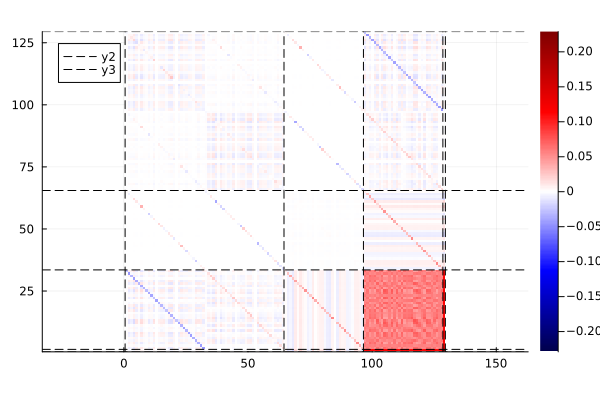

In [47]:
colplot(H, nn=nn)

In [48]:
mean(H)

0.0040704173683572785

In [29]:
function scanl(f::Function, init::Any, iter)
    res = [init]
    acc = init
    for elem in iter
        acc = f(acc, elem)
        push!(res, acc)
    end
    return res
end

scanl (generic function with 2 methods)

In [30]:
function jointplot(H)
    colplot(hcat(H, H))
    grayplot!(H)
end

jointplot (generic function with 1 method)

In [83]:
flat(grads::Zygote.Grads) = reduce(vcat, [vec(grads[t]) for t in grads.params])

flat (generic function with 1 method)

## Fisher Information

In [40]:
# Compute the Fisher for x_1, theta
# Note: y_1, the training label is not used here.

F = zeros(129, 129)

for i in 1:length(y)
    p_1 = sigmoid(nn(xs[i]))
    p_0 = 1 .- p_1

    g_w_y_1, = Flux.destructure(gradient(m -> Flux.Losses.logitbinarycrossentropy(m(xs[i]), 1), nn))
    g_w_y_0, = Flux.destructure(gradient(m -> Flux.Losses.logitbinarycrossentropy(m(xs[i]), 0), nn))

    # WRONG
    # g_expd = p_1 .* g_w_y_1 + p_0 .* g_w_y_0

    F += p_1 .* g_w_y_1 * g_w_y_1'
    F += p_0 .* g_w_y_0 * g_w_y_0'
end

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(2 => 32, σ)   # 96 parameters
│   summary(x) = "2-element Vector{Float64}"
└ @ Flux ~/.julia/packages/Flux/EHgZm/src/layers/stateless.jl:60


In [70]:
EF = zeros(129, 129)

for i in 1:length(y)
    g, = Flux.destructure(gradient(m -> Flux.Losses.logitbinarycrossentropy(m(xs[i]), y[i]), nn))
    EF += g * g'
end

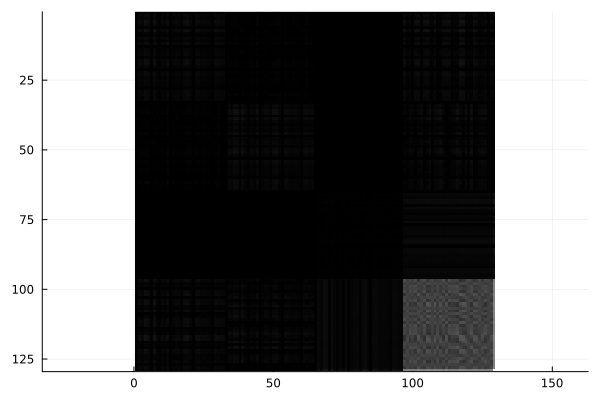

In [41]:
grayplot(F)

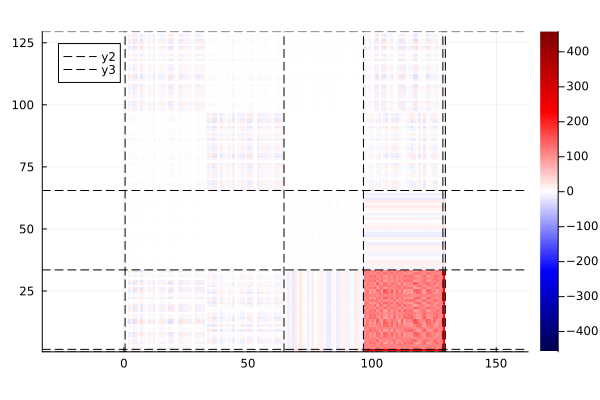

In [44]:
colplot(F, nn=nn)

In [50]:
mean(F) / mean(H)

1986.424267158689

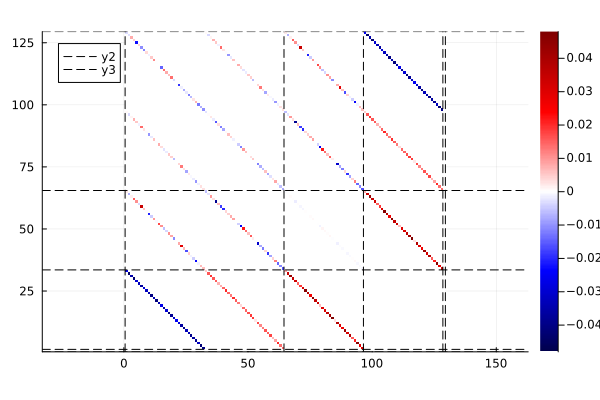

In [52]:
colplot(H - F / 2000, nn=nn)

In [43]:
maximum(abs, F)

457.9616365171969

## Kron

In [69]:
mutable struct Kron1
#    kfacs :: Union{Vector{Tuple{AbstractArray, AbstractArray}},Vector{Matrix},Nothing}
    kfacs :: Vector{Tuple{AbstractArray, AbstractArray}}
end

Kron = Kron1
    
# mutable struct KronDecomposed
#     eigenvectors :: Union{AbstractArray,Nothing}
#     eigenvalues :: Union{AbstractArray,Nothing}
#     damping :: Bool
# end


Kron1

### Addition

In [17]:
import Base: +, ==, *

function (+)(l::Kron, r::Kron)
    @assert length(l.kfacs) == length(r.kfacs)
    kfacs = [Tuple(Hi + Hj for (Hi, Hj) in zip(Fi, Fj))
                for (Fi, Fj) in zip(l.kfacs, r.kfacs)]
    return Kron(kfacs)
end

function (==)(l::Kron, r::Kron)
    return l.kfacs == r.kfacs
end

# H = [[Fi + Fj for (Fi, Fj) in zip(Fi_row, Fj_row)] for (Fi_row, Fj_row) in zip(H.kfacs, H_batch.kfacs)]
#        kfacs = [[Hi.add(Hj) for Hi, Hj in zip(Fi, Fj)]
#                 for Fi, Fj in zip(self.kfacs, other.kfacs)]

== (generic function with 185 methods)

### Tests

In [9]:
using Test

In [10]:
left = Kron([([1 2], [3 4])])
right = Kron([([5 6], [7 8])])
total = left + right
@test total.kfacs == [([6 8], [10 12])]

Test Passed

In [16]:
left = Kron([([1 2], [3 4]), ([11 12], [13 14])])
right = Kron([([5 6], [7 8]), ([15 16], [17 18])])
total = left + right
@test total.kfacs == [([6 8], [10 12]), ([26 28], [30 32])]

Test Passed

In [13]:
left = Kron([])
total = left + left
@test total == left

Test Passed

In [15]:
left = Kron([([1 2], [3 4]), ([], [])])
right = Kron([([5 6], [7 8])])
@test_throws AssertionError left + right

Test Passed
      Thrown: AssertionError

In [8]:
collect(zip([1, 2, 3], [4, 5, 6, 7]))

3-element Vector{Tuple{Int64, Int64}}:
 (1, 4)
 (2, 5)
 (3, 6)

### Scaling

In [31]:
function (*)(l::Real, r::Kron)
        kfacs = [Tuple(^(l, 1/length(F)) * Hi for Hi in F) for F in r.kfacs]
        return Kron(kfacs)
end

(*)(l::Kron, r::Real) = (*)(r, l)

* (generic function with 311 methods)

### Tests

In [38]:
left = 4
right = Kron([([5 6], [7 8])])
@test left * right == right * left
@test (left * right).kfacs == [([10 12], [14 16])]

Test Passed

## Andrei's code

In [7]:
function init(model)
    kfacs = []

    for p in Flux.params(model)
        if ndims(p) == 1  # bias
            P = size(p, 1)
            push!(kfacs, [zeros(P, P)])
        elseif 4 >= ndims(p) >= 2  # fully connected or conv
            if ndims(p) == 2  # fully connected
                P_in, P_out = size(p)
            elseif ndims(p) > 2
                P_in, P_out = size(p, 1), prod(size(p)[2:end])
            end
            
            push!(kfacs, [
                zeros(P_in, P_in),
                zeros(P_out, P_out)
            ])
        else
            error("Invalid parameter shape in network.")
        end
    end
    # @show kfacs
    # @show get_array_sizes(kfacs)
    # @show print_arrays(kfacs)
    return Kron(kfacs)
end

init (generic function with 1 method)

In [8]:
function fitBeta(la::Laplace, data; batched::Bool=false, batchsize::Int, override::Bool=true)
    if override
        H = init(la.model)          
        loss = 0.0
        n_data = 0
    end

    # Training:
    for d in data
        x, y = d
        loss_batch, H_batch =_curv_closure(la.est_params.curvature, x, y, length(data))
        loss += loss_batch
        @show(H_batch)
        @show(H)
        H = [[Fi + Fj for (Fi, Fj) in zip(Fi_row, Fj_row)] for (Fi_row, Fj_row) in zip(H.kfacs, H_batch.kfacs)]
        n_data += batchsize
    end

    # Store output:
    la.loss = loss                                                           # Loss
    la.posterior.H = H                                                                 # Hessian
    la.P = posterior_precision(la)                                           # posterior precision
    la.Σ = posterior_covariance(la)                                          # posterior covariance
    return la.n_data = n_data                                                # number of observations
end

fitBeta (generic function with 1 method)

In [45]:
# fitting kron
function fitAux(la, train_loader, override=true, damping=false)
    if override
        H_facs = nothing
    end

    if !isnothing(H_facs)
        n_data_old = la.n_data
        n_data_new = length(train_loader)
        la.posterior.H = init(la.model) # re-init H non-decomposed
        # discount previous Kronecker factors to sum up properly together with new ones
        H_facs = _rescale_factors(H_facs, n_data_old / (n_data_old + n_data_new))
    end

    fitBeta(la, train_loader, batched=false, batchsize=1, override=override)

    if isnothing(H_facs)
        H_facs =la.posterior.H
    else
        # discount new factors that were computed assuming N = n_data_new
        la.posterior.H = _rescale_factors(la.posterior.H, n_data_new / (n_data_new + n_data_old))
        H_facs += la.posterior.H
    end
    # Decompose to self.H for all required quantities but keep H_facs for further inference
    la.posterior.H = decompose(la.H_facs, damping=damping)
end

fitAux (generic function with 3 methods)

In [46]:
function _curv_closure(curvature, x, y, N)
    return kron(curvature, x, y, N) #la.backend.kron(X, y, N=N)
end

_curv_closure (generic function with 1 method)

In [47]:
function posterior_precision(la::Laplace, H=la.posterior.H, P₀=la.prior.P₀)
    @assert !isnothing(H) "Hessian not available. Either no value supplied or Laplace Approximation has not yet been estimated."
    return H .+ P₀
end

posterior_precision (generic function with 3 methods)

In [48]:
function posterior_covariance(la::Laplace, P=posterior_precision(la))
    @assert !isnothing(P) "Posterior precision not available. Either no value supplied or Laplace Approximation has not yet been estimated."
    return inv(P)
end

posterior_covariance (generic function with 2 methods)

In [49]:
function kron(curvature, x, y, N)
    #context = ifelse(self.stochastic, KFAC, KFLR)
    loss = curvature.factor * curvature.loss_fun(x, y)
    𝐠 = gradient(() -> curvature.loss_fun(x, y), Flux.params(curvature.model))
    𝐠 = reduce(vcat, [vec(𝐠[i]') for i in curvature.params])  
    # backpack(context()) do
    #     backward(loss)
    # end
    kron = Kron(𝐠)
    @show(kron)
    kron = _rescale_kron_factors(kron, length(y), N)
    return curvature.factor * loss, kron#curvature.factor * detach(loss), curvature.factor * kron
end

kron (generic function with 1 method)

In [50]:
function decompose(kron,damping=false)
    """
    Eigendecompose Kronecker factors and turn into `KronDecomposed`.
    
    Parameters
    ----------
    damping : bool
        use damping

    Returns
    -------
    kron_decomposed : KronDecomposed
    """
    eigvecs = []
    eigvals = []
    for F in kron.kfacs
        Qs = []
        ls = []
        for Hi in F
            l, Q = symeig(Hi)
            push!(Qs, Q)
            push!(ls, l)
        push!(eigvecs, Qs)
        push!(eigvals, ls)
        end
    end
    return KronDecomposed(eigvecs, eigvals, damping=damping)
end

decompose (generic function with 2 methods)

In [51]:
function _rescale_factors(kron, factor)
    for F in kron.kfacs
        if length(F) == 2
            F[1] *= factor
        end
    end
    return kron
end

_rescale_factors (generic function with 1 method)

In [52]:
function _rescale_kron_factors(kron, M, N)
    # Renormalize Kronecker factor to sum up correctly over N data points with batches of M
    # for M=N (full-batch) just M/N=1
    for F in kron.kfacs
        if length(F) == 2
            F[1] *= M/N
        end
    end
    return kron
end

_rescale_kron_factors (generic function with 1 method)

In [7]:
function _get_kron_factors(la)
    return Kron([p.kfac for p la.model.parameters])
end

LoadError: syntax: invalid iteration specification

In [54]:
# dataloader = DataLoader((X, Y), batchsize=10)

200-element DataLoader(::Tuple{Matrix{Float64}, Matrix{Float64}}, batchsize=10)
  with first element:
  (1×10 Matrix{Float64}, 1×10 Matrix{Float64},)

In [55]:
# function fit_la(nn, dataloader, X, y)
#     la_b = Laplace(nn; likelihood=:regression, λ=λ, subset_of_weights=:all)
#     fitAux(la_b, dataloader)
#     plot(la_b, X, y )
# end

fit_la (generic function with 1 method)

In [6]:
# fit_la(nn, dataloader, X, y)

## LA

In [64]:
la = Laplace(nn; likelihood=:classification, backend=:EmpiricalFisher)
fit!(la, zip(xs, y))

2000

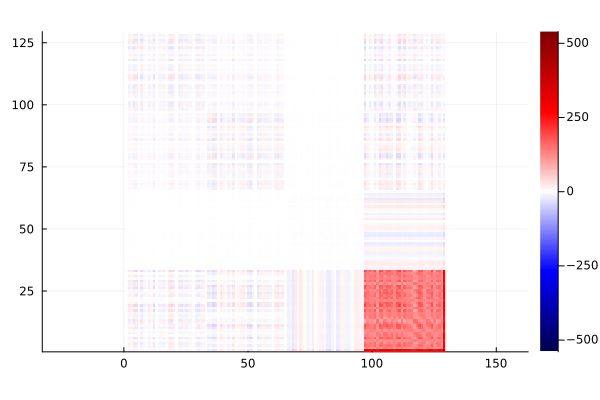

In [66]:
colplot(la.posterior.H)

In [72]:
colplot(EF - la.posterior.H)

In [73]:
EF - la.posterior.H

129×129 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [65]:
la.posterior.H

129×129 Matrix{Float64}:
  0.359727    -2.40035    -1.44206  …   -1.63373    1.45776    -0.67492
 -2.40035     18.3918     11.4501       15.5185    -8.66445    10.2621
 -1.44206     11.4501      7.43352      11.0633    -4.31573     8.68321
 -3.28489     25.3054     15.8163       21.6344   -11.6902     14.5949
  2.6609     -19.9837    -12.8537      -18.4137     8.35167   -13.5565
  0.552803    -3.8957     -2.35266  …   -2.82826    2.213      -1.39863
  3.14547    -22.9372    -13.8772      -17.0461    12.6359     -8.95251
  1.30719     -9.72173    -6.23196      -8.82828    4.16928    -6.37663
  0.640138    -5.16869    -3.40791      -5.24727    1.75337    -4.33403
 -2.01056     15.9153     10.119        14.4055    -6.65844    10.5703
 -1.00694      7.48689     4.60924  …    6.00969   -3.78216     3.65615
  2.77183    -22.4703    -14.6936      -22.2952     7.95636   -18.0649
  0.0973861   -0.753399   -0.47201      -0.64873    0.343841   -0.442702
  ⋮                                 ⋱      